## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

## Cleaning steps

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])

In [11]:
# Extract the year from the datetime object and create a new column "year"
temp_county['year'] = [date[:4]
 for date in temp_county.loc[:,'dt']]

In [12]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [13]:
disaster_county = disaster_df.copy()

In [14]:
# Extract the year from the datetime object and create a new column "Year"
disaster_county['Year'] = [date[-4:]
 for date in disaster_county.loc[:,'Declaration Date']]

In [15]:
# group by year county name and year
avg_year_temp = temp_county.groupby(['countyname','year']).mean().reset_index()

In [16]:
# left join on county and year
join_county = pd.merge(disaster_county, avg_year_temp, how='left', left_on=['County','Year'], right_on=['countyname','year'])


In [17]:
# temperature data grouped by state and year
dftemp1 = temp_county.copy()
dftemp2 = dftemp1.groupby(['state','year'], as_index=False).mean()

In [18]:
# disaster data, creating a new column with just the year, taken from the declaration date
dfdisaster1 = disaster_df.copy()
dfdisaster1['Year'] = [date[-4:]
 for date in dfdisaster1.loc[:,'Declaration Date']]

In [19]:
# left join on the disaster data, joined on state and year
join_state = pd.merge(dfdisaster1, dftemp2, how='left', left_on=['State','Year'], right_on=['state','year'])
join_state_1 = join_state[['Declaration Number','Declaration Date','State','state','Year','year','AverageTemperature']]
join_state.dropna().head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,state,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n
89,DR-91,Disaster,01/29/1959,IN,Clay County,Flood,Flood,01/29/1959,01/29/1959,11/01/1960,...,No,Yes,Yes,1959,IN,1959,10.942726,0.279107,40.53000,-86.154286
181,DR-183,Disaster,12/24/1964,CA,Alpine County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
182,DR-183,Disaster,12/24/1964,CA,Amador County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
183,DR-183,Disaster,12/24/1964,CA,Butte County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
184,DR-183,Disaster,12/24/1964,CA,Colusa County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871


## Further Data Cleaning Steps

In [20]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = [date[5:7]
 for date in temp_county.loc[:,'dt']]

In [21]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [22]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


In [23]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)

In [67]:
temp_county_region['date'] = temp_county_region['dt'].astype('datetime64[D]')
temp_county_region['date_delta'] = (temp_county_region['date'] - temp_county_region['date'].min())  / np.timedelta64(1,'D')
temp_county_region.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname,month,season,region,date,date_delta
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,1,Winter,west south central south region,1820-01-01,27819.0
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,2,Winter,west south central south region,1820-02-01,27850.0
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,3,Spring,west south central south region,1820-03-01,27879.0
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,4,Spring,west south central south region,1820-04-01,27910.0
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,5,Spring,west south central south region,1820-05-01,27940.0


# Statistical Inference

### Average yearly temperature, sorted by season

Text(0.5,1,'Fall')

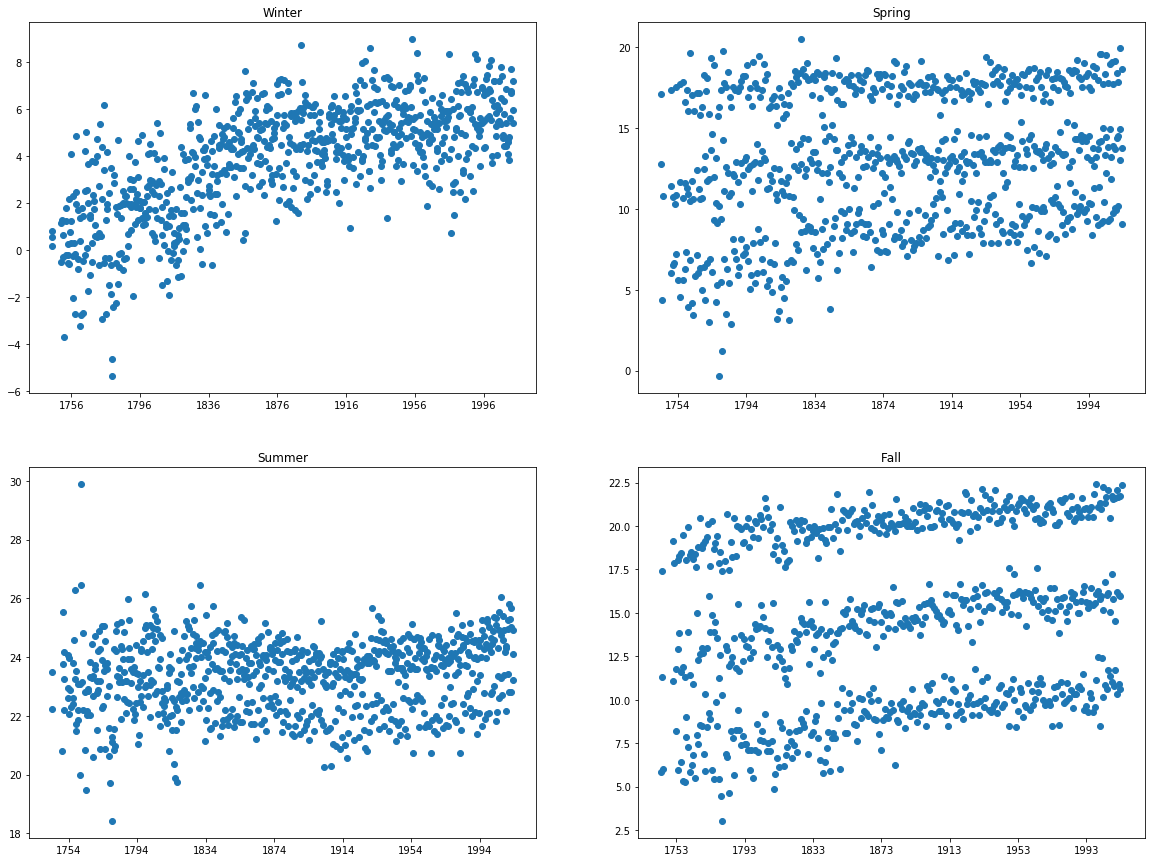

In [82]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby('dt').mean()[['AverageTemperature']].reset_index()
winter['date'] = winter['dt'].astype('datetime64[ns]')
winter['date_delta'] = (winter['date'] - winter['date'].min())  / np.timedelta64(1,'D')
ax[0,0].scatter(winter['date'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')           
           
spring = temp_county_region[temp_county_region.season == 'Spring'].groupby('dt').mean()[['AverageTemperature']].reset_index()
spring['date'] = spring['dt'].astype('datetime64[ns]')
spring['date_delta'] = (spring['date'] - spring['date'].min())  / np.timedelta64(1,'D')
ax[0,1].scatter(spring['date'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby('dt').mean()[['AverageTemperature']].reset_index()
summer['date'] = summer['dt'].astype('datetime64[ns]')
summer['date_delta'] = (summer['date'] - summer['date'].min())  / np.timedelta64(1,'D')
ax[1,0].scatter(summer['date'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby('dt').mean()[['AverageTemperature']].reset_index()
fall['date'] = fall['dt'].astype('datetime64[ns]')
fall['date_delta'] = (fall['date'] - fall['date'].min())  / np.timedelta64(1,'D')
ax[1,1].scatter(fall['date'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')           
           

These four scatter plots show the correlation of date and average temperature. Each of the temperature values were averaged for a given date, and each season is portrayed. Winter shows a positive correlation of time and temperature, while summer does not show much correlation. Both spring and fall have three bands, which can be attributed to the three months for the given season. Since spring and fall are transition periods between hot and cold seasons, the bands make sense. Fall shows some positive correlation within each band, as time goes on, temperature is rising, and a similar trend can be seen with the lower temperatures in spring. These correlations will be useful for further statistical analysis and linear regression. 

In [84]:
print('winter corr: ', winter['date_delta'].corr(winter.AverageTemperature),'\n'
      'spring corr: ', spring['date_delta'].corr(spring.AverageTemperature),'\n'
      'summer corr: ', summer['date_delta'].corr(summer.AverageTemperature),'\n'
      'fall corr: ', fall['date_delta'].corr(fall.AverageTemperature))

winter corr:  0.6772901881046355 
spring corr:  0.20298380917659387 
summer corr:  0.11891006431560357 
fall corr:  0.2192467943048275


### linear regression model  - winter

In [27]:
X = winter[['date_delta']].values
y = winter[['AverageTemperature']].values

X = X.reshape(-1,1)
y = y.reshape(-1,1)

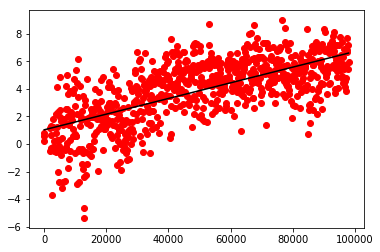

In [28]:
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(X, y,color='r')

plt.plot(X, model.predict(X),color='k')
plt.show()

In [29]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [5.68560373e-05]
Model intercept: [1.03204912]


In [30]:
# train and test data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [31]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [32]:
# Compute and print R^2 and RMSE
print("R^2 (Score): {}".format(lm.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2 (Score): 0.43479366974035566
Root Mean Squared Error: 1.7902025406886657


### Average yearly temperature, sorted by month

I will now explore temperature as it changes by month, which is essentially a more detailed view of the seasons. 

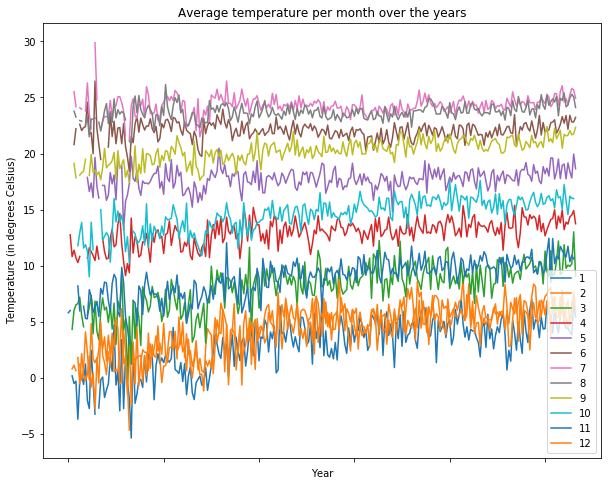

In [33]:
# temperature over time by month
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','month']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per month over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

It can be observed that the summer months (July, August, and June) have the highest average temperature over the years and the winter months (January, February, and December) have the lowest temperatures. This follows the expected trend, but the question of is the average temperature increasing over time is still unknown, without some statistical analysis. 

Text(0.5,1,'November')

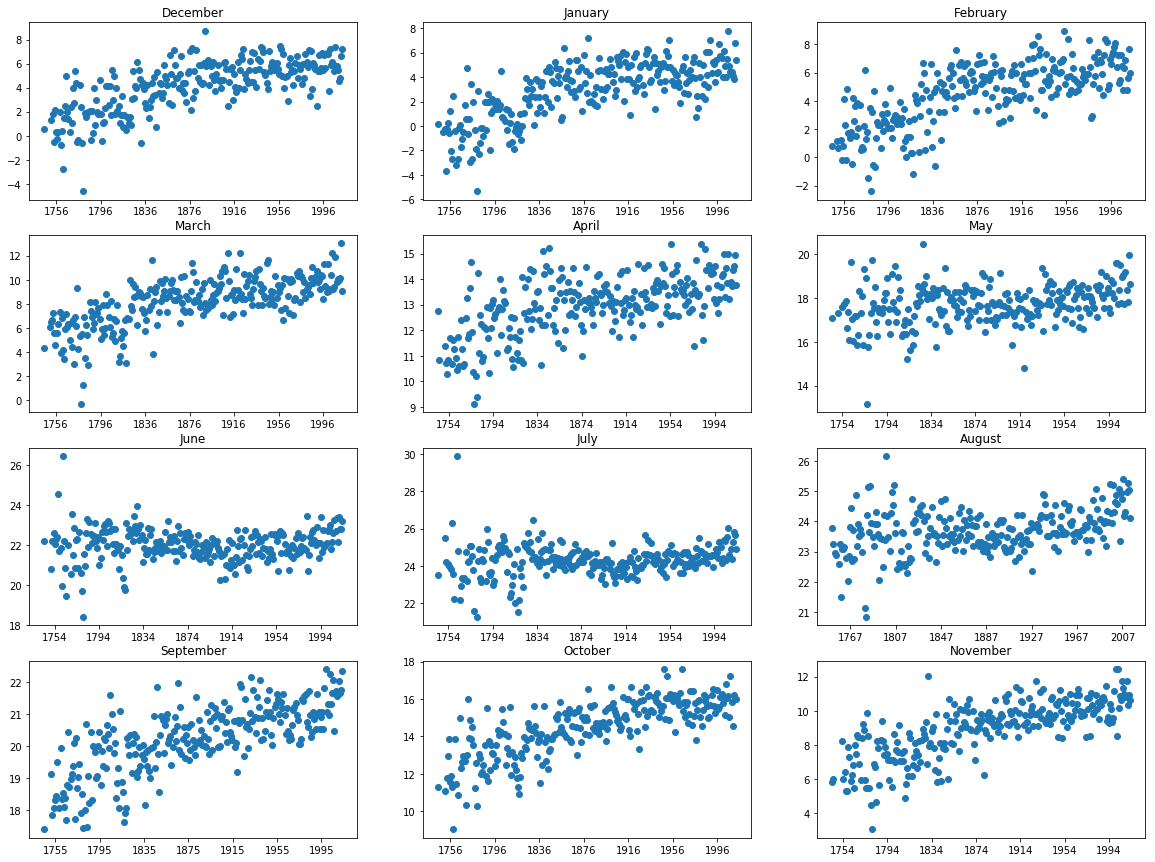

In [34]:
fig, ax = plt.subplots(4,3,figsize=(20,15))

dec = temp_county_region[temp_county_region.month == 12].groupby('dt').mean()[['AverageTemperature']].reset_index()
dec['date'] = dec['dt'].astype('datetime64[ns]')
ax[0,0].scatter(dec['date'].tolist() ,dec['AverageTemperature'].tolist())
ax[0,0].set_title('December')           
                    
jan = temp_county_region[temp_county_region.month == 1].groupby('dt').mean()[['AverageTemperature']].reset_index()
jan['date'] = jan['dt'].astype('datetime64[ns]')
ax[0,1].scatter(jan['date'].tolist() ,jan['AverageTemperature'].tolist())
ax[0,1].set_title('January')       

feb = temp_county_region[temp_county_region.month == 2].groupby('dt').mean()[['AverageTemperature']].reset_index()
feb['date'] = feb['dt'].astype('datetime64[ns]')
ax[0,2].scatter(feb['date'].tolist() ,feb['AverageTemperature'].tolist())
ax[0,2].set_title('February')       


mar = temp_county_region[temp_county_region.month == 3].groupby('dt').mean()[['AverageTemperature']].reset_index()
mar['date'] = mar['dt'].astype('datetime64[ns]')
ax[1,0].scatter(mar['date'].tolist() ,mar['AverageTemperature'].tolist())
ax[1,0].set_title('March')           
                    
apr = temp_county_region[temp_county_region.month == 4].groupby('dt').mean()[['AverageTemperature']].reset_index()
apr['date'] = apr['dt'].astype('datetime64[ns]')
ax[1,1].scatter(apr['date'].tolist() ,apr['AverageTemperature'].tolist())
ax[1,1].set_title('April')       

may = temp_county_region[temp_county_region.month == 5].groupby('dt').mean()[['AverageTemperature']].reset_index()
may['date'] = may['dt'].astype('datetime64[ns]')
ax[1,2].scatter(may['date'].tolist() ,may['AverageTemperature'].tolist())
ax[1,2].set_title('May')


jun = temp_county_region[temp_county_region.month == 6].groupby('dt').mean()[['AverageTemperature']].reset_index()
jun['date'] = jun['dt'].astype('datetime64[ns]')
ax[2,0].scatter(jun['date'].tolist() ,jun['AverageTemperature'].tolist())
ax[2,0].set_title('June')           
                    
jul = temp_county_region[temp_county_region.month == 7].groupby('dt').mean()[['AverageTemperature']].reset_index()
jul['date'] = jul['dt'].astype('datetime64[ns]')
ax[2,1].scatter(jul['date'].tolist() ,jul['AverageTemperature'].tolist())
ax[2,1].set_title('July')       

aug = temp_county_region[temp_county_region.month == 8].groupby('dt').mean()[['AverageTemperature']].reset_index()
aug['date'] = aug['dt'].astype('datetime64[ns]')
ax[2,2].scatter(aug['date'].tolist() ,aug['AverageTemperature'].tolist())
ax[2,2].set_title('August')


sep = temp_county_region[temp_county_region.month == 9].groupby('dt').mean()[['AverageTemperature']].reset_index()
sep['date'] = sep['dt'].astype('datetime64[ns]')
ax[3,0].scatter(sep['date'].tolist() ,sep['AverageTemperature'].tolist())
ax[3,0].set_title('September')           
                    
octo = temp_county_region[temp_county_region.month == 10].groupby('dt').mean()[['AverageTemperature']].reset_index()
octo['date'] = octo['dt'].astype('datetime64[ns]')
ax[3,1].scatter(octo['date'].tolist() ,octo['AverageTemperature'].tolist())
ax[3,1].set_title('October')       

nov = temp_county_region[temp_county_region.month == 11].groupby('dt').mean()[['AverageTemperature']].reset_index()
nov['date'] = nov['dt'].astype('datetime64[ns]')
ax[3,2].scatter(nov['date'].tolist() ,nov['AverageTemperature'].tolist())
ax[3,2].set_title('November')

These are the correlations of average temperature over datetime for each month. Most months, except summer, show a positive, linear correlation. However, around May-August, there is a curving feature where the temperature around the late 1800s starts to decrease. These correlations will be further analyzed, but they serve useful to show that in general, temperature has been increasing with time.

### linear regression model  - december

In [86]:
dec['date_delta'] = (dec['date'] - dec['date'].min())  / np.timedelta64(1,'D')


X = dec[['date_delta']].values
y = dec[['AverageTemperature']].values

X = X.reshape(-1,1)
y = y.reshape(-1,1)

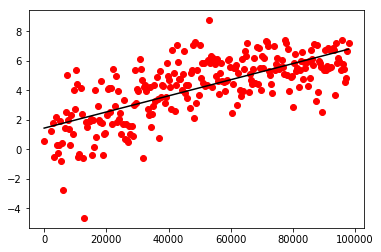

In [87]:
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(X, y,color='r')

plt.plot(X, model.predict(X),color='k')
plt.show()

In [89]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
print("Pearson corr   :", dec['date_delta'].corr(dec['AverageTemperature']))

Model slope:     [5.4675248e-05]
Model intercept: [1.44323175]
Pearson corr   : 0.7100828393861939


In [90]:
# train and test data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [91]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [92]:
# Compute and print R^2 and RMSE
print("R^2 (Score): {}".format(lm.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2 (Score): 0.4925259792345097
Root Mean Squared Error: 1.4434024045712506


### Disaster data

Part of the hypothesis is to see if natural disasters in the United States have increased due to temperature changes. To examine the disaster side, I will look at the disaster data frame and see how disasters have changed over time. 

In [35]:
# create a copy of the disaster data, extracting the columns with the necessary data
disaster = disaster_county.copy()
disaster = disaster[['Declaration Type','Declaration Date','Year','State','County','Disaster Type']]
disaster.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type
0,Disaster,05/02/1953,1953,GA,NaN,Tornado
1,Disaster,05/15/1953,1953,TX,NaN,Tornado
2,Disaster,05/29/1953,1953,LA,NaN,Flood
3,Disaster,06/02/1953,1953,MI,NaN,Tornado
4,Disaster,06/06/1953,1953,MT,NaN,Flood


Looking at the disaster DataFrame, there are repeats in the disasters since the data is recorded at the county level. However, it is possible that the disaster was across multiple counties. To account for the duplicates, I will drop any duplicate with the same Declaration date, disaster type, and state. 

In [36]:
disaster_unique = disaster.drop_duplicates(subset=['Declaration Date', 'Disaster Type', 'State']) 
disaster_unique.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type
0,Disaster,05/02/1953,1953,GA,NaN,Tornado
1,Disaster,05/15/1953,1953,TX,NaN,Tornado
2,Disaster,05/29/1953,1953,LA,NaN,Flood
3,Disaster,06/02/1953,1953,MI,NaN,Tornado
4,Disaster,06/06/1953,1953,MT,NaN,Flood


In [37]:
# count total number of disasters, see which disasters are most prevalent
disaster_unique.groupby('Disaster Type').agg('count')['Declaration Type'].sort_values(ascending=False).head()

Disaster Type
Storm        919
Flood        772
Fire         680
Hurricane    313
Tornado      163
Name: Declaration Type, dtype: int64

The first five disasters with the most occurences in the United States are: storms, floods, fires, hurricanes, and tornados. I will focus on these disasters to examine the trends in the data, since they make up most of the data.

### Joined temperature and disaster data

To view correlations between temperature and disaster I must join the disaster and temperature data. I will first join on state and then join the nearest dates, using pd.merge_asof. 

In [38]:
# copy of disaster data to organize for the join
disasterdf = disaster.copy()
disasterdf['date'] = disasterdf['Declaration Date'].astype('datetime64[ns]')
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date', 'Disaster Type', 'State','Year']) 
disasterdf.head()

# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf['date'] = tempdf['dt'].astype('datetime64[ns]')
tempdf = tempdf[['date','dt','AverageTemperature','state','county','year','season','month', 'region']].sort_values('date')
tempdf.head()

# nearest join on date (with a left join on state first)
joindf = pd.merge_asof(disasterdf, tempdf, on='date',left_by='State',right_by='state',direction='nearest').dropna()


In [39]:
# removing rows where the join dates did not match since the disaster data only went up to Sept 2013
joindf = joindf[joindf['date']<='2013-09-30']
joindf.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type,date,dt,AverageTemperature,state,county,year,season,month,region
89,Disaster,01/29/1959,1959,IN,Clay County,Flood,1959-01-29,1959-02-01,0.961,IN,Decatur,1959,Winter,2.0,east north central midwest region
181,Disaster,12/24/1964,1964,CA,Alpine County,Flood,1964-12-24,1965-01-01,13.677,CA,San Diego,1965,Winter,1.0,pacific west region
182,Disaster,12/24/1964,1964,OR,Baker County,Flood,1964-12-24,1965-01-01,3.656,OR,Lane,1965,Winter,1.0,pacific west region
183,Disaster,12/29/1964,1964,WA,Asotin County,Flood,1964-12-29,1965-01-01,1.133,WA,King,1965,Winter,1.0,pacific west region
185,Disaster,01/18/1965,1965,NV,Douglas County,Flood,1965-01-18,1965-02-01,8.848,NV,Clark,1965,Winter,2.0,mountain west region


In [40]:
# groupby to get the disaster count and average temperature for the scatter plot
join_state1 = join_state[['Declaration Date','State','Disaster Type','Year','AverageTemperature','state','year']]
join_state_group = join_state1.groupby(['Year']).agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})
join_state_group.head()

,Disaster Type,AverageTemperature
Year,,
1953,13,14.249234
1954,17,12.873133
1955,18,11.691972
1956,16,12.726184
1957,16,13.351205


Text(0,0.5,'Disaster Count')

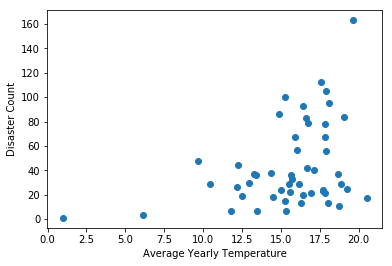

In [41]:
joindf1 = joindf.groupby('Year').agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})

plt.scatter(joindf1['AverageTemperature'], joindf1['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

This scatterplot is the yearly average temperature against the disaster count across the nation. Further statistical analysis will help disclose whether or not there is a correlation.

Furthermore, I will look at specific regions, or other distinct groups of states, and look at the disasters prone to each region. For example, hurricanes occur mostly on the east coast, so I will look at those states and that specific disaster. I will go through the top five disasters (storms, floods, fires, hurricanes, and tornados) and their respective regions. 

### Storms

Text(0,0.5,'Disaster Count')

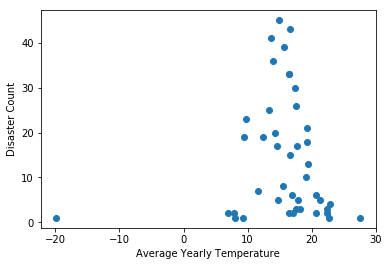

In [42]:
stormdf = joindf[joindf['Disaster Type']=='Storm']
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

### Floods

In [43]:
flooddf = joindf[(joindf['Disaster Type']=='Flood')&
             (joindf['region'].str.contains('south region'))|
             (joindf['region'].str.contains('northeast region'))|
             (joindf['region'].str.contains('midwest region'))]

Text(0,0.5,'Disaster Count')

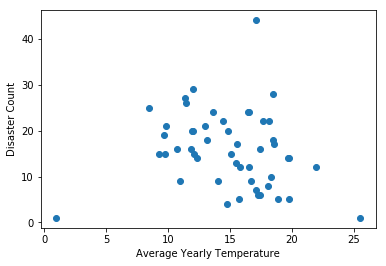

In [44]:
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

### Fires

In [45]:
firedf = joindf[(joindf['Disaster Type']=='Fire')&
             (joindf['region'].str.contains('west region'))]

Text(0,0.5,'Disaster Count')

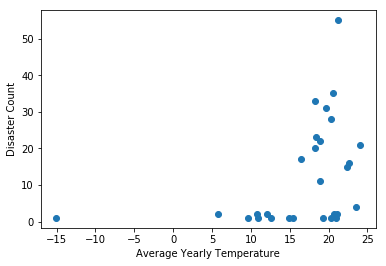

In [46]:
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

### Hurricanes

In [47]:
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')&
             (joindf['region'].str.contains('south region')) |
             (joindf['region'].str.contains('northeast region'))]

Text(0,0.5,'Disaster Count')

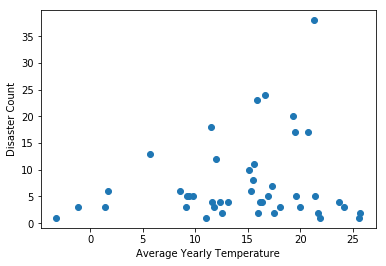

In [48]:
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

### linear regression model

In [94]:
hurricanedf.head()

,Disaster Type,AverageTemperature
Year,,
1965,5,21.4064
1967,2,12.5635
1968,2,21.7290
1969,5,19.5556
1970,2,25.7375


In [95]:
X = hurricanedf[['AverageTemperature']].values
y = hurricanedf[['Disaster Type']].values

X = X.reshape(-1,1)
y = y.reshape(-1,1)

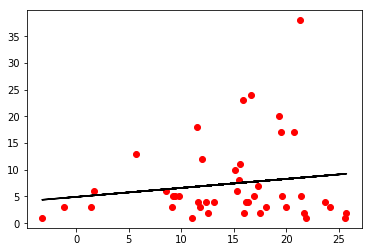

In [96]:
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(X, y,color='r')

plt.plot(X, model.predict(X),color='k')
plt.show()

In [98]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
print("Pearson corr   :", hurricanedf.corr())

Model slope:     [0.1681531]
Model intercept: [4.92654987]
Pearson corr   :                     Disaster Type  AverageTemperature
Disaster Type            1.000000            0.148883
AverageTemperature       0.148883            1.000000


In [99]:
# train and test data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [100]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [101]:
# Compute and print R^2 and RMSE
print("R^2 (Score): {}".format(lm.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2 (Score): -0.19778681822025224
Root Mean Squared Error: 5.0903149882759395


### Tornados 

In [49]:
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')&
             (joindf['region'].str.contains('midwest region')) |
             (joindf['region'].str.contains('west south central'))]

Text(0,0.5,'Disaster Count')

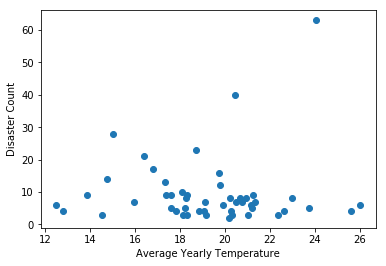

In [50]:
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

For each of the five major disasters, there is not an evident correlation between the disaster count and average yearly temperature. With further statistical analysis, we can determine whether or not there is a correlation.